## Código para testar o modelo de YOLO

---

In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
from paddleocr import PaddleOCR
import os
import re
import requests

/home/joao/Documents/VisComp/compvis-car/.venv/lib/python3.12/site-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


### Identificação de placas de carros:

In [2]:
def classify_image(image_path):    
    model = YOLO('last.pt')  
    results = model(image_path)
    
    # Display results
    for result in results:
        img_rgb = cv2.cvtColor(result.plot(show=False), cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 10))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()

def classify_and_crop(image_path):
    # Load model
    model = YOLO('last.pt')
    
    # Run inference
    results = model(image_path)
    
    # Read the original image
    original_image = cv2.imread(image_path)
    imgnames = []


    # Iterate over results
    for i, result in enumerate(results):
        boxes = result.boxes.xyxy.cpu().numpy()  # Get bounding boxes in (x1, y1, x2, y2) format

        for j, (x1, y1, x2, y2) in enumerate(boxes):
            # Convert coordinates to integers
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

            # Crop the image
            cropped = original_image[y1:y2, x1:x2]

            # Convert BGR to RGB for displaying
            cropped_rgb = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
            # Save the cropped image
            output_filename = f'cropped_{i}_{j}.png'
            imgnames.append(output_filename)
            cv2.imwrite(output_filename, cropped)

            # Show the cropped region
            plt.figure(figsize=(4, 4))
            plt.imshow(cropped_rgb)
            plt.axis('off')
            plt.title(f'Cropped #{i}-{j}')
            plt.show()
    return imgnames

def classify_and_save(image_path):
    model = YOLO('last.pt')
    results = model(image_path)
    
    # Read the original image
    original_image = cv2.imread(image_path)
    imgnames = []
    
    # Iterate over results
    for i, result in enumerate(results):
        boxes = result.boxes.xyxy.cpu().numpy()  # Get bounding boxes in (x1, y1, x2, y2) format

        for j, (x1, y1, x2, y2) in enumerate(boxes):
            # Convert coordinates to integers
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

            # Crop the image
            cropped = original_image[y1:y2, x1:x2]

            # Convert BGR to RGB for displaying
            cropped_rgb = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
            # Save the cropped image
            output_filename = f'plates/cropped_{i}_{j}.png'
            imgnames.append(output_filename)
            cv2.imwrite(output_filename, cropped)
            

### Lendo o texto das placas

In [ ]:
import cv2
import numpy as np
import re
from paddleocr import PaddleOCR

def change_char_in_position(word, position):
    if position < len(word):
        if word[position].isdigit():
            digit = word[position]
            if digit == '8':
                word = word[:position] + 'B' + word[position+1:]
            elif digit == '1':
                word = word[:position] + 'I' + word[position+1:]
    return word

def detect_blue_strip(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return False

    # Recorta a parte de cima da imagem (20% superior)
    height = image.shape[0]
    top_part = image[0:int(height * 0.2), :]

    # Converte para HSV para facilitar a detecção de azul
    hsv = cv2.cvtColor(top_part, cv2.COLOR_BGR2HSV)
    lower_blue = np.array([100, 50, 50])
    upper_blue = np.array([140, 255, 255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Calcula a proporção de pixels azuis
    blue_ratio = cv2.countNonZero(mask) / (top_part.shape[0] * top_part.shape[1])
    return blue_ratio > 0.05  # Se mais de 5% for azul, consideramos placa nova

ocr = PaddleOCR(use_angle_cls=True, lang='en', show_log=False)

def extract_plate_from_image(image_path):
    is_new_plate = detect_blue_strip(image_path)
    result = ocr.ocr(image_path, cls=True)
    
    if not result or result[0] == None:
        print("No text detected.")
        return None    
    
    detected_words = []
    for line in result:
        for word_info in line:
            if word_info[1][0].lower() == "brasil":
                is_new_plate = True  # reforça com OCR, mas a imagem é mais confiável
            else:
                detected_words.append((word_info[1][0], word_info[1][1]))
                
    print(f"Palavras detectadas: {detected_words}")
    print(f"É nova placa? {is_new_plate}")    
    
    for word_tuple in detected_words:
        word = word_tuple[0].replace("-", "")
        confidence = word_tuple[1]                
            
        if (re.fullmatch(r'[A-Z]{3}\d{4}', word) and not is_new_plate) or re.fullmatch(r'[A-Z]{3}\d[A-Z]\d{2}', word):
            return word
        
        else:
            if word[0].isdigit():
                word = change_char_in_position(word, 0)
            if word[1].isdigit():
                word = change_char_in_position(word, 1)
            if word[2].isdigit():
                word = change_char_in_position(word, 2)
            if is_new_plate and word[4].isdigit():
                word = change_char_in_position(word, 4)
                            
            if re.match(r'^[A-Z]{3}\d{4}$', word) or re.match(r'^[A-Z]{3}\d{1}[A-Z]\d{2}$', word):
                return word
            
        
            
    return None


### Separando Placas:


In [4]:
imgs_path = "imgs/"
if not os.path.exists(imgs_path):
    os.makedirs(imgs_path)
    
plates_path = "plates/"
if not os.path.exists(plates_path):
    os.makedirs(plates_path)
    
# get the images from imgs
imgs = os.listdir(imgs_path)
for img in imgs:
    img_path = os.path.join(imgs_path, img)
    print(f"Processing {img_path}")
    
    # Classify and crop the image
    classify_and_save(img_path)
    break


Processing imgs/52.png

image 1/1 /home/joao/Documents/VisComp/compvis-car/imgs/52.png: 384x640 2 License_Plates, 69.1ms
Speed: 3.0ms preprocess, 69.1ms inference, 212.9ms postprocess per image at shape (1, 3, 384, 640)


### Testando com imagens reais


image 1/1 /home/joao/Documents/VisComp/compvis-car/imgs/21.png: 384x640 3 License_Plates, 62.4ms
Speed: 1.7ms preprocess, 62.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


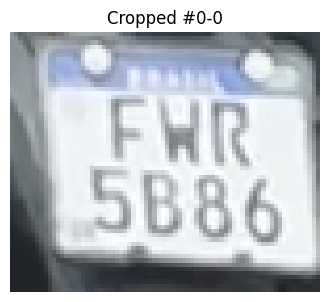

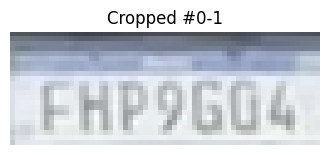

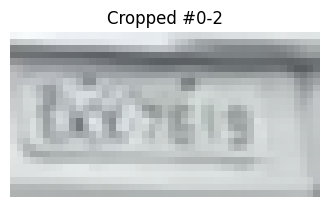

In [5]:
image_path = 'imgs/21.png'
imgs = classify_and_crop(image_path)

In [8]:
for img in imgs:
    print(f"Processing {img}")
    plate = extract_plate_from_image(img)   
    if plate:
        print(f"Detected plate: {plate}")
    break

Processing cropped_0_0.png
Palavras detectadas: [('FWR', 0.9598544239997864), ('5886', 0.9001538753509521)]
É nova placa? True


IndexError: string index out of range

In [6]:
plates = []
for img in imgs:
    print(f"Processing image: {img}")
    plate = extract_plate_from_image(img)
    print(f"Plate detected: {plate}")
    if plate:
        plates.append(plate)
    print('-'*20)


Processing image: cropped_0_0.png
Palavras detectadas: [('FWR', 0.9598544239997864), ('5886', 0.9001538753509521)]
É nova placa? True


IndexError: string index out of range

----

In [ ]:
image_path = '../compvis-car/Brazil/files/domain1/7471000.jpg'
imgs = classify_and_crop(image_path)

In [ ]:
plates = []
for img in imgs:
    print(f"Processing image: {img}")
    plate = extract_plate_from_image(img)
    print(f"Plate detected: {plate}")
    if plate:
        plates.append(plate)
    print('-'*20)


In [ ]:
token = os.getenv('API_TOKEN', 'não-encontrado')
token

In [ ]:
api_url = 'https://wdapi2.com.br/consulta/{placa}/{token}'

placa = plates[1]
token = os.getenv('API_TOKEN', 'default_token_value')
response = requests.get(api_url.format(placa=placa, token=token))
if response.status_code == 200:
    data = response.json()
    print(f"API Response: {data}")

In [ ]:
def get_infos(data):
    info = {}
    marca = data['marca']
    modelo = data['modelo']
    ano = data['ano']
    cor = data['cor']

    info = {
        'marca': marca,
        'modelo': modelo,
        'ano': ano,
        'cor': cor
    }

    extra = data['extra']

    campos_interesse = ['municipio', 'nacionalidade', 'sub_segmento']
    for chave in campos_interesse:
        if chave in extra:
            info[chave] = extra[chave]
        else:
            info[chave] = None
            
    fipe = data['fipe']['dados']
    sum = 0
    i = 0
    for dados in fipe:
        valor = dados['texto_valor']
        valor = valor.replace("R$", "")
        valor = valor.replace(".", "")
        valor = valor.replace(",", ".")
        valor = float(valor)
        sum += valor
        i += 1
        
    media = sum / i
    info['fipe'] = media
    
    return info

info = get_infos(data)
print(info)
            